In [1]:
import numpy as np
from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss, WeightedSmoothL1Loss
from torchmetrics import R2Score

import json
import torch
import pandas as pd
from torch.utils.data import DataLoader
import pytorch_lightning as pl

import matplotlib.pyplot as plt

import seaborn as sns

sns.set(style="whitegrid")


from bondnet.data.dataset import ReactionNetworkDatasetGraphs

from bondnet.model.gated_reaction_network_lightning import (
    GatedGCNReactionNetworkLightning,
)

from bondnet.utils import seed_torch, pickle_dump, parse_settings
from bondnet.model.training_utils import (
    evaluate_breakdown,
    get_grapher,
    load_model_lightning,
)
from bondnet.data.dataloader import DataLoaderReactionNetwork
from bondnet.data.dataset import ReactionNetworkDatasetGraphs
from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss, WeightedSmoothL1Loss

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dataset(
    train_path="../../dataset/Training_set_HEPoP_after_filtering.json",
    test_path="../../dataset/Holdout_test_set_HEPoP_after_filtering.json",
):
    # train_df_path = "../../dataset/Training_set_HEPoP_after_filtering.json"
    # test_df_path = "/home/rdguha95/Holdout_test_set_HEPoP_after_filtering.json"
    train_df = pd.read_json(train_path)
    test_df = pd.read_json(test_path)
    frames = [train_df, test_df]
    full_df = pd.concat(frames)
    full_df.reset_index(inplace=True)
    full_df.drop(columns="index", inplace=True)
    full_df = full_df.drop_duplicates(subset=["reaction_id"])
    full_df = full_df.reset_index(drop=True)
    return full_df, test_df, train_df


full_df, test_df, train_df = get_dataset()

In [3]:
test_df["functional_group_reacted"] = test_df[
    "extra_feat_global_reactant_functional_group_reacted"
]
# test_df["extra_feat_global_product_functional_group_reacted"] = [None] * len(test_df)

In [4]:
torch.set_float32_matmul_precision("high")
from bondnet.test_utils import get_defaults

config = get_defaults()
config["model"]["extra_features"] = ["bond_length", "functional_group_reacted"]
# config["model"]["extra_features"] = ["bond_length", "functional_group_reacted"]

In [5]:
config["model"]

{'conv': 'GatedGCNConv',
 'augment': False,
 'classifier': False,
 'classif_categories': 3,
 'cat_weights': [1.0, 1.0, 1.0],
 'embedding_size': 24,
 'epochs': 100,
 'extra_features': ['bond_length', 'functional_group_reacted'],
 'extra_info': [],
 'filter_species': [3, 5],
 'fc_activation': 'ReLU',
 'fc_batch_norm': True,
 'fc_dropout': 0.2,
 'fc_hidden_size_1': 256,
 'fc_hidden_size_shape': 'flat',
 'fc_num_layers': 1,
 'gated_activation': 'ReLU',
 'gated_batch_norm': False,
 'gated_dropout': 0.1,
 'gated_graph_norm': False,
 'gated_hidden_size_1': 512,
 'gated_hidden_size_shape': 'flat',
 'gated_num_fc_layers': 1,
 'gated_num_layers': 2,
 'gated_residual': True,
 'learning_rate': 0.003,
 'precision': 32,
 'loss': 'mse',
 'num_lstm_iters': 3,
 'num_lstm_layers': 1,
 'restore': False,
 'weight_decay': 0.0,
 'max_epochs': 1000,
 'max_epochs_transfer': 10,
 'transfer': False,
 'filter_outliers': True,
 'freeze': True,
 'reactant_only': False}

In [6]:
dataset = ReactionNetworkDatasetGraphs(
    grapher=get_grapher(
        ["functional_group_reacted", "bond_length"],
    ),
    file="../../dataset/Holdout_test_set_HEPoP_after_filtering.json",
    target="dG_sp",
    classifier=False,
    classif_categories=3,
    filter_species=[3, 6],
    filter_outliers=False,
    filter_sparse_rxns=False,
    debug=False,
    extra_keys=["functional_group_reacted", "bond_length"],
    extra_info=["functional_group_reacted"],
)
test_dataset_loader = DataLoaderReactionNetwork(
    dataset, batch_size=len(dataset), shuffle=False
)

fg_list ['PDK', 'amide', 'carbamate', 'carboxylic acid ester', 'cyclic carbonate', 'epoxide', 'imide', 'lactam', 'lactone', 'nitrile', 'urea']
reading file from: ../../dataset/Holdout_test_set_HEPoP_after_filtering.json
rxn raw len: 1000
Program finished in 7.682296107000184 seconds
.............failures.............
reactions len: 1000
valid ind len: 1000
bond break fail count: 		0
default fail count: 		0
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 1000
features: 2642
labels: 1000
molecules: 2642
constructing graphs & features....
number of graphs valid: 2642
number of graphs: 2642


In [7]:
dataset

Dataset ReactionNetworkDatasetGraphs
Length: 1000
Feature: atom, size: 20
Feature: bond, size: 8
Feature: global, size: 19
Feature: atom, name: ['total_degree', 'total_H', 'is_in_ring', 'ring_size_3', 'ring_size_4', 'ring_size_5', 'ring_size_6', 'ring_size_7', 'chemical_symbol_C', 'chemical_symbol_F', 'chemical_symbol_H', 'chemical_symbol_N', 'chemical_symbol_O', 'chemical_symbol_Mg', 'chemical_symbol_Li', 'chemical_symbol_S', 'chemical_symbol_Cl', 'chemical_symbol_P', 'chemical_symbol_O', 'chemical_symbol_Br']
Feature: bond, name: ['metal bond', 'ring inclusion', 'ring size_3', 'ring size_4', 'ring size_5', 'ring size_6', 'ring size_7', 'bond_length']
Feature: global, name: ['num atoms', 'num bonds', 'molecule weight', 'charge one hot', 'charge one hot', 'charge one hot', 'charge one hot', 'charge one hot', 'hydrolysed functional group', 'hydrolysed functional group', 'hydrolysed functional group', 'hydrolysed functional group', 'hydrolysed functional group', 'hydrolysed functional gr

In [8]:
dataset.molecules[0].functional_group

'amide'

In [9]:
import os

os.listdir(
    "/home/santiagovargas/dev/bondnet/bondnet/scripts/notebooks/top_models/w_func_best/"
)

#'model_epoch_epoch=239.ckpt',
# 'last-v95.ckpt', 3.339927490234375
# 'model_epoch_epoch=769.ckpt', 2.69
# 'model_lightning_epoch=343-val_l1=2.23.ckpt',
# 'last-v99.ckpt'

['model_epoch_epoch=249-v1.ckpt',
 'model_epoch_epoch=149.ckpt',
 'model_epoch_epoch=99.ckpt',
 'model_epoch_epoch=299.ckpt',
 'model_epoch_epoch=349-v1.ckpt',
 'model_epoch_epoch=449.ckpt',
 'model_epoch_epoch=449-v1.ckpt',
 'model_epoch_epoch=499-v1.ckpt',
 'model_epoch_epoch=199-v1.ckpt',
 'model_epoch_epoch=399.ckpt',
 'model_epoch_epoch=99-v1.ckpt',
 'model_epoch_epoch=349.ckpt',
 'model_epoch_epoch=399-v1.ckpt',
 'model_epoch_epoch=299-v1.ckpt',
 'model_epoch_epoch=249.ckpt',
 'model_epoch_epoch=199.ckpt',
 'model_epoch_epoch=149-v1.ckpt',
 'model_epoch_epoch=499.ckpt']

In [87]:
config["restore"] = True
model_path = "/home/santiagovargas/dev/bondnet/bondnet/scripts/notebooks/top_models/w_func_best/model_epoch_epoch=199-v1.ckpt"
config["restore_path"] = model_path
model_restart = load_model_lightning(config, load_dir=model_path)
# load model to gpu
model_restart.cuda()

:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
:::MODEL LOADED:::


GatedGCNReactionNetworkLightning(
  (embedding): UnifySize(
    (linears): ModuleDict(
      (atom): Linear(in_features=20, out_features=12, bias=False)
      (bond): Linear(in_features=8, out_features=12, bias=False)
      (global): Linear(in_features=19, out_features=12, bias=False)
    )
  )
  (gated_layers): ModuleList(
    (0): GatedGCNConv(
      (activation): ReLU()
      (A): LinearN(
        (fc_layers): ModuleList(
          (0): Linear(in_features=12, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): Identity()
        )
      )
      (B): LinearN(
        (fc_layers): ModuleList(
          (0): Linear(in_features=12, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): Identity()
        )
      )
      (C): LinearN(
        (fc_layers): ModuleList(
          (0): Linear(in_features=12, out_features=256, bias=Tr

In [88]:
model_restart.hparams

"augment":               False
"conv":                  GatedGCNConv
"embedding_size":        12
"eta_min":               1e-06
"fc_activation":         ReLU
"fc_batch_norm":         True
"fc_dropout":            0.2
"fc_hidden_size":        [1024, 1024, 1024]
"fc_num_layers":         3
"gated_activation":      ReLU
"gated_batch_norm":      False
"gated_dropout":         0.2
"gated_graph_norm":      False
"gated_hidden_size":     [256, 256]
"gated_num_fc_layers":   2
"gated_num_layers":      2
"gated_residual":        False
"in_feats":              {'atom': 20, 'bond': 8, 'global': 19}
"learning_rate":         0.001
"loss_fn":               mse
"lr":                    0.001
"max_epochs":            1000
"num_lstm_iters":        11
"num_lstm_layers":       2
"outdim":                1
"reactant_only":         False
"scheduler_name":        reduce_on_plateau
"set2set_ntypes_direct": ['global']
"wandb":                 True
"warmup_epochs":         10
"weight_decay":          1e-05

In [89]:
def evaluate(model, nodes, data_loader, device=None):
    """
    basic loop for training a classifier. Gets mae

    Args:
        model(pytorch model): pytorch model
        nodes(dict): node feature dictionary
        data_loader(loader obj): loader object with data to eval
        device(str): cpu/gpu
    Returns:
        mae(float): mae
    """
    metric_fn = WeightedL1Loss(reduction="sum")
    model.eval()

    dict_result_raw = {}

    with torch.no_grad():
        count, mae, mae_no_std = 0.0, 0.0, 0.0
        for batched_graph, label in data_loader:
            feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in nodes}
            target = label["value"]
            norm_atom = label["norm_atom"]
            # norm_atom = None
            norm_bond = label["norm_bond"]
            # norm_bond = None
            stdev = label["scaler_stdev"]
            reaction_types = label["reaction_types"]
            # print device batched_graph is on
            # move batched_graph to device
            batched_graph = batched_graph.to(device)
            if device is not None:
                feats = {k: v.to(device) for k, v in feats.items()}
                target = target.to(device)
                norm_atom = norm_atom.to(device)
                norm_bond = norm_bond.to(device)
                stdev = stdev.to(device)
            functional_group_reacted = [
                i.extra_info["functional_group_reacted"] for i in label["reaction"]
            ]

            pred = model(
                graph=batched_graph,
                feats=feats,
                reactions=label["reaction"],
                norm_atom=norm_atom,
                norm_bond=norm_bond,
                reverse=False,
            )

            pred = pred.view(-1)

            if device is None:
                pred_np = pred.detach().numpy()
                target_np = target.detach().numpy()
                stdev_np = stdev.detach().numpy()
            else:
                pred_np = pred.detach().cpu().numpy()
                target_np = target.detach().cpu().numpy()
                stdev_np = stdev.detach().cpu().numpy()

            t1 = torch.tensor(pred_np)
            t2 = torch.tensor(target_np)
            t2 = t2.squeeze()
            r2score = R2Score()
            sc = r2score(t1, t2)
            target_np = target_np.reshape(-1)
            x = pred_np * stdev_np
            y = target_np * stdev_np
            print(x.shape, y.shape)
            # plt.scatter(pred_np, target_np)
            plt.scatter(x, y)
            df_pred = pd.DataFrame([x, y, stdev_np, functional_group_reacted])

            # Show each performance with scatter plots
            # sns.scatterplot(x=pred_np * stdev_np,y=target_np * stdev_np, palette="Set3", inner="points", bw =.2, cut=2, linewidth=3)

            min_val = (
                np.min([np.min(pred_np * stdev_np), np.min(target_np * stdev_np)]) - 0.5
            )
            max_val = (
                np.max([np.max(pred_np * stdev_np), np.max(target_np * stdev_np)]) + 0.5
            )
            plt.ylim(min_val, max_val)
            plt.xlim(min_val, max_val)
            # plt.ylim(-10, 10)
            # plt.xlim(-10, 10)
            plt.title("Predicted vs. True")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.grid(False)
            # plt.savefig("./{}.png".format("test_best"))

            mae += metric_fn(pred, target, stdev).detach().item()
            mae_no_std += metric_fn(pred, target, None).detach().item()
            count += len(target)

    l1_acc = mae / count
    l1_acc_no_std = mae_no_std / count
    return l1_acc, l1_acc_no_std, sc, df_pred

(1000,) (1000,)


/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:89: UserWarning: Input size (torch.Size([1000])) is different from the target size (torch.Size([1000, 1])) or weight size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  input.size(), target.size(), weight.size()
/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:82: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


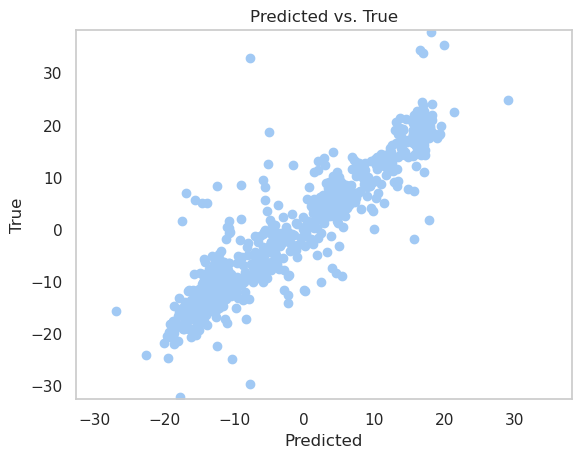

In [90]:
feature_names = ["atom", "bond", "global"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
l1, l1_no_std, sc, df_pred = evaluate(
    model_restart, feature_names, test_dataset_loader, device=device
)

In [91]:
sns_data = df_pred.T
sns_data = sns_data.rename(
    columns={
        0: "bondnet_prediction",
        1: "dft_value",
        2: "std_dev",
        3: "functional_group_reacted",
    }
)

In [92]:
sns_data

,bondnet_prediction,dft_value,std_dev,functional_group_reacted
0,4.883876,9.592024,13.53306,amide
1,15.878011,21.046833,13.53306,amide
2,16.388128,17.347187,13.53306,amide
3,19.519558,19.723385,13.53306,amide
4,3.789163,5.705586,13.53306,amide
...,...,...,...,...
995,3.480018,9.07908,13.53306,imide
996,10.194283,5.970581,13.53306,imide
997,4.042307,14.828502,13.53306,imide
998,1.956485,3.960562,13.53306,imide


/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


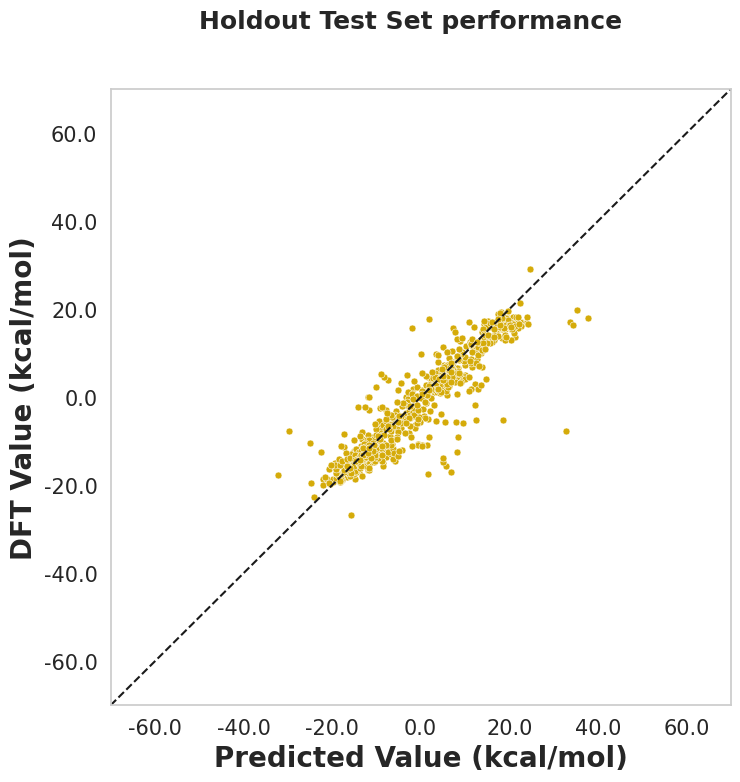

In [93]:
f, ax = plt.subplots(figsize=(8, 8))
sns.set(style="whitegrid")
ax = sns.scatterplot(
    x="dft_value",
    y="bondnet_prediction",
    data=sns_data,
    marker="o",
    s=25,
    color=sns.xkcd_rgb["burnt yellow"],
)


f.suptitle("Holdout Test Set performance", fontsize=18, fontweight="bold")
ax.set_xlabel("Predicted Value (kcal/mol)", size=20, alpha=1, weight="bold")
ax.set_ylabel("DFT Value (kcal/mol)", size=20, alpha=1, weight="bold")
ax.set_xlim(-70, 70)
ax.set_ylim(-70, 70)

ax.set_yticklabels(ax.get_yticks(), size=15)
ax.set_xticklabels(ax.get_xticks(), size=15)
plt.grid(False)
X_plot = np.linspace(-70, 70, 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, "k--")
plt.show()

In [94]:
adj_factor = sns_data["dft_value"][0] - test_df["dG_sp"][0]
sns_data["mean_shifted_dft"] = sns_data["dft_value"] - adj_factor
sns_data["deviation"] = abs(sns_data["dft_value"] - sns_data["bondnet_prediction"])

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


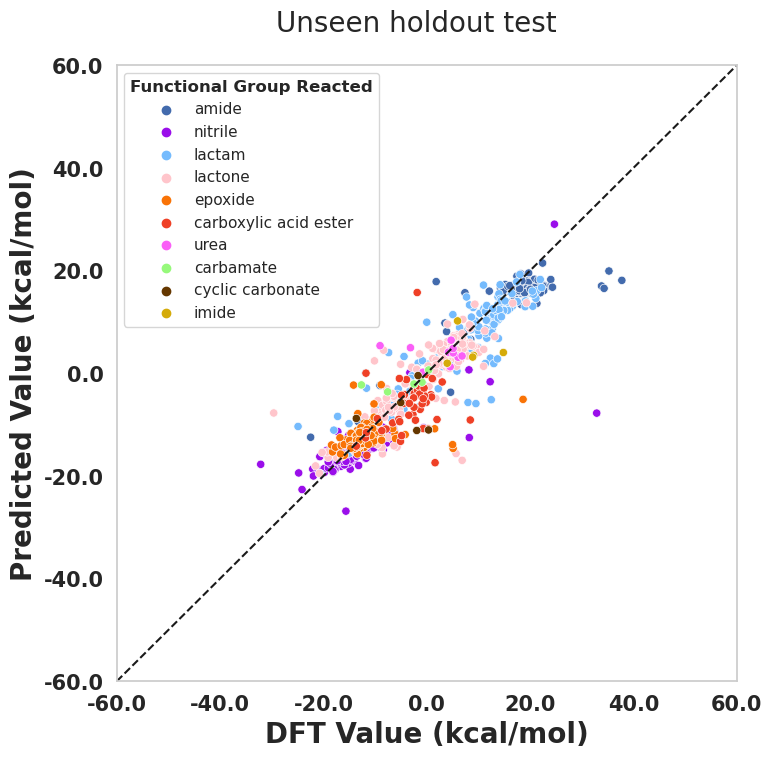

In [95]:
f, ax = plt.subplots(figsize=(8, 8))
sns.set(style="whitegrid")

sns.set_palette("pastel")
sns_ten_fg_subset = sns_data[
    sns_data["functional_group_reacted"].isin(
        [
            "epoxide",
            "lactone",
            "nitrile",
            "amide",
            "lactam",
            "carboxylic acid ester",
            "urea",
            "imide",
            "carbamate",
            "cyclic carbonate",
        ]
    )
]
ax = sns.scatterplot(
    x="dft_value",
    y="bondnet_prediction",
    data=sns_ten_fg_subset,
    marker="o",
    hue="functional_group_reacted",
    palette=[
        sns.xkcd_rgb["french blue"],
        sns.xkcd_rgb["violet"],
        sns.xkcd_rgb["sky blue"],
        sns.xkcd_rgb["light rose"],
        sns.xkcd_rgb["orange"],
        sns.xkcd_rgb["tomato"],
        sns.xkcd_rgb["light magenta"],
        sns.xkcd_rgb["light green"],
        sns.xkcd_rgb["brown"],
        sns.xkcd_rgb["burnt yellow"],
    ],
)
f.suptitle("Unseen holdout test", y=0.95, fontsize=20)

ax.set_xlabel("DFT Value (kcal/mol)", size=20, alpha=1, weight="bold")
ax.set_ylabel("Predicted Value (kcal/mol)", size=20, alpha=1, weight="bold")
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)


legend = ax.legend(loc="upper left", title="Functional Group Reacted")
legend.get_title().set_fontsize("12")  # Set font size
legend.get_title().set_fontweight("bold")  # Set font weight
ax.set_yticklabels(ax.get_yticks(), size=15, weight="bold")
ax.set_xticklabels(ax.get_xticks(), size=15, weight="bold")
plt.grid(False)
X_plot = np.linspace(-60, 60, 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, "k--")
plt.savefig("Holdout_test_set.png", dpi=600)
plt.show()

In [96]:
# compute the mean absolute error of each functional group
fg_mae = sns_ten_fg_subset.groupby("functional_group_reacted").mean()["deviation"]
fg_mae

functional_group_reacted
amide                    2.927018
carbamate                3.159985
carboxylic acid ester    4.631908
cyclic carbonate         5.466601
epoxide                  2.230058
imide                    5.668079
lactam                   3.205710
lactone                  2.950805
nitrile                  2.234941
urea                     3.641541
Name: deviation, dtype: float64

In [97]:
fg_mae = sns_ten_fg_subset["deviation"].mean()
print(fg_mae)

2.832208740234375


In [53]:
for functional_group in list(
    set(sns_ten_fg_subset["functional_group_reacted"].tolist())
):
    # get the subset of the data for each functional group
    fg_subset = sns_ten_fg_subset[
        sns_ten_fg_subset["functional_group_reacted"] == functional_group
    ]
    # compute r2 between dft and bondnet prediction
    t1 = torch.tensor(fg_subset["bondnet_prediction"].tolist())
    t2 = torch.tensor(fg_subset["dft_value"].tolist())
    t2 = t2.squeeze()
    r2score = R2Score()
    sc = r2score(t1, t2)
    # print("{}:\t\t\t{}".format(functional_group, sc))
    # print with uniform spacing
    if len(functional_group) >= 23:
        print("{}:\t{}".format(functional_group, sc))
    if len(functional_group) >= 15:
        print("{}:\t\t{}".format(functional_group, sc))
    elif len(functional_group) >= 7:
        print("{}:\t\t\t{}".format(functional_group, sc))
    else:
        print("{}:\t\t\t\t{}".format(functional_group, sc))

cyclic carbonate:		0.9109202027320862
carbamate:			-0.2536332607269287
epoxide:			0.2048945426940918
nitrile:			0.4921509623527527
amide:				0.6561521291732788
lactam:				0.7521530389785767
carboxylic acid ester:		-1.6891429424285889
lactone:			0.7262470722198486
urea:				0.20291763544082642
imide:				-3.1580452919006348
